## Import Libraries 

In [1]:
import warnings
import sys
sys.path.insert(0, '../../src')
warnings.filterwarnings('ignore')

In [2]:
import train_test
import bostonDataset
import network
import dataset
import sanityChecks
import torch 
from torch.utils.data import random_split 
import scrapbook as sb
from statistics import mean

## Dataset

In [3]:
#Dataset Parameters 
n_features = 13
n_samples= 506
n_target = 1

In [4]:
X,Y = bostonDataset.boston_data()

# Train test split for dataset 
real_dataset = dataset.CustomDataset(X,Y)
train_size = round(0.8 * n_samples)
test_size = n_samples - train_size
train_data, test_data = random_split(real_dataset,[train_size,test_size])

        X1    X2    X3   X4     X5     X6    X7      X8   X9    X10   X11  \
0  0.00632  18.0  2.31  0.0  0.538  6.575  65.2  4.0900  1.0  296.0  15.3   
1  0.02731   0.0  7.07  0.0  0.469  6.421  78.9  4.9671  2.0  242.0  17.8   
2  0.02729   0.0  7.07  0.0  0.469  7.185  61.1  4.9671  2.0  242.0  17.8   
3  0.03237   0.0  2.18  0.0  0.458  6.998  45.8  6.0622  3.0  222.0  18.7   
4  0.06905   0.0  2.18  0.0  0.458  7.147  54.2  6.0622  3.0  222.0  18.7   

      X12   X13     Y  
0  396.90  4.98  24.0  
1  396.90  9.14  21.6  
2  392.83  4.03  34.7  
3  394.63  2.94  33.4  
4  396.90  5.33  36.2  


## Parameters 

In [5]:
n_epochs = 5000
batch_size = 100
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### MSE Threshold 

Fetch MSE threshold for training the GAN 

The GAN will be trained until the threshold MSE is achieved or until it completes 5000 epochs 

The threshold mse is the mean mse of Catboost over 10 runs

In [6]:
books = sb.read_notebooks("./BaseLine_Model_Output")
catboostMSE = []
for nb in books.notebooks: 
    catboostMSE.append(nb.scraps['Catboost MSE'].data)
threshold_mse = mean(catboostMSE)

## GAN Model

**Training GAN for n_epochs number of epochs** 

In [7]:
generator = network.Generator(n_features+1).to(device)
discriminator = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

In [8]:
print(generator)
print(discriminator)

Generator(
  (hidden1): Linear(in_features=14, out_features=50, bias=True)
  (hidden2): Linear(in_features=50, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)
Discriminator(
  (hidden1): Linear(in_features=14, out_features=25, bias=True)
  (hidden2): Linear(in_features=25, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [9]:
discLossG1,genLossG1 = train_test.training_GAN(discriminator,generator,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,device)

sb.glue("GAN_1 Generator Loss",genLossG1)
sb.glue("GAN_1 Discriminator Loss",discLossG1)

In [10]:
GAN1_metrics = train_test.test_generator(generator,test_data,device)

sb.glue("GAN_1 Metrics",GAN1_metrics)

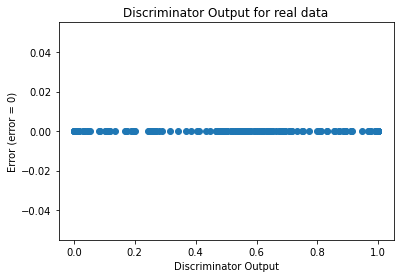

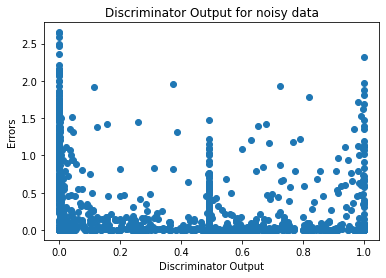

In [11]:
sanityChecks.discProbVsError(real_dataset,discriminator,device)

**Training GAN until mse of y_pred is > baseline_mse or n_epochs < 5000**

In [12]:
generator2 = network.Generator(n_features+1).to(device)
discriminator2 = network.Discriminator(n_features+1).to(device)
criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(generator2.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator2.parameters(), lr=0.01, betas=(0.5, 0.999))

In [13]:
discLossG2,genLossG2 = train_test.training_GAN_2(discriminator2,generator2,disc_opt,gen_opt,train_data,test_data,batch_size,threshold_mse,criterion,device)

sb.glue("GAN_2 Generator Loss",genLossG2)
sb.glue("GAN_2 Discriminator Loss",discLossG2)

Number of epochs needed 5000


In [14]:
GAN2_metrics=train_test.test_generator_2(generator2,test_data,device)
sb.glue("GAN_2 Metrics",GAN2_metrics)

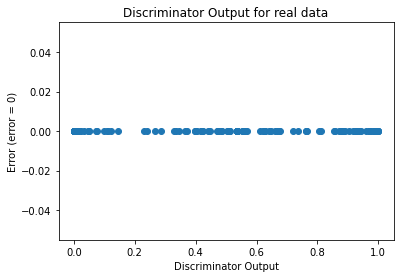

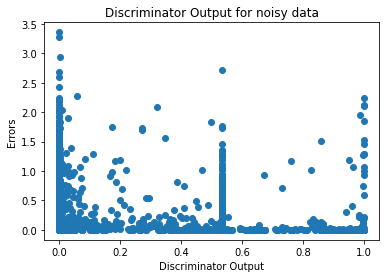

In [15]:
sanityChecks.discProbVsError(real_dataset,discriminator2,device)